## Error Corrected After Every Gate Qubit Adder

In [ ]:
%load_ext autoreload
%autoreload 2

import qiskit
import common
import gates
import constants


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def logical_register(name: str) -> list:
    return [qiskit.QuantumRegister(1, name), qiskit.QuantumRegister(8, f"{name}l")]

# Create quantum registers
creq_ca = []
areq_ca = []
breq_ca = []
for i in range(constants.bits):
    creq_ca.append(logical_register(f"c{i}"))
    areq_ca.append(logical_register(f"a{i}"))
    breq_ca.append(logical_register(f"b{i}"))
breq_ca.append(logical_register(f"b{constants.bits}"))


# Combine quantum registers into a single list
req_ca = []
for i in range(constants.bits):
    req_ca.extend(creq_ca[i])
    req_ca.extend(areq_ca[i])
    req_ca.extend(breq_ca[i])
req_ca.extend(breq_ca[constants.bits])

classical_req = qiskit.ClassicalRegister(constants.bits + 1, "result")
qc_ca = qiskit.QuantumCircuit(*req_ca, classical_req)

# Add shor setup
for i in range(constants.bits):
    qc_ca = gates.add_shor_setup(qc_ca, creq_ca[i])
    qc_ca = gates.add_shor_setup(qc_ca, areq_ca[i])
    qc_ca = gates.add_shor_setup(qc_ca, breq_ca[i])
qc_ca = gates.add_shor_setup(qc_ca, breq_ca[constants.bits])

# Add X gates to set the initial values
for i in range(constants.bits):
    if constants.a[::-1][i] == "1":
        qc_ca = gates.add_x(qc_ca, areq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, areq_ca[i])
    if constants.b[::-1][i] == "1":
        qc_ca = gates.add_x(qc_ca, breq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i])


# Add the carry and sum gates
for i in range(constants.bits):
    if i != constants.bits - 1:
        qc_ca = gates.add_carry(qc_ca, creq_ca[i], areq_ca[i], breq_ca[i], creq_ca[i + 1])

        qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, areq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i + 1])
    else:
        qc_ca = gates.add_carry(qc_ca, creq_ca[i], areq_ca[i], breq_ca[i], breq_ca[i + 1])
        qc_ca = gates.add_cx(qc_ca, areq_ca[i], breq_ca[i])

        qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, areq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i])
        qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i + 1])

for i in reversed(range(constants.bits)):
    qc_ca = gates.add_sum(qc_ca, creq_ca[i], areq_ca[i], breq_ca[i])

    qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i])
    qc_ca = gates.add_shor_teardown(qc_ca, areq_ca[i])
    qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i])

    if i != 0:
        qc_ca = gates.add_reverse_carry(qc_ca, creq_ca[i - 1], areq_ca[i - 1], breq_ca[i - 1], creq_ca[i])

        qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i - 1])
        qc_ca = gates.add_shor_teardown(qc_ca, areq_ca[i - 1])
        qc_ca = gates.add_shor_teardown(qc_ca, breq_ca[i - 1])
        qc_ca = gates.add_shor_teardown(qc_ca, creq_ca[i])

print(f"{qc_ca.num_qubits} qubits used")

for i in range(constants.bits + 1):
    qc_ca.measure(breq_ca[i][0], classical_req[i])

# qc_ca.draw("mpl")

117 qubits used


Backend: ibm_sherbrooke
Most likely state: 00010


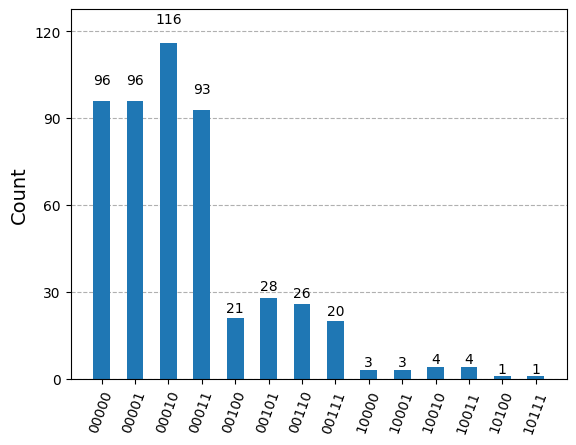

In [ ]:
# raise common.StopExecution

simulator_ca = common.RealQuantumComputer(qc_ca, 512)
counts_ca = simulator_ca.run("result")
print(f"Backend: {simulator_ca.backend_name()}")
print(f"Most likely state: {simulator_ca.most_common()}")
simulator_ca.plot()